### Setup Dependencies and Shared Objects

Execute this first to get all of the imports, env variables, and shared objects loaded.

In [1]:
from datetime import datetime
import os
from typing import List, Dict
import tiktoken


from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents.base import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_community.document_loaders import (
    # UnstructuredExcelLoader,
    # UnstructuredHTMLLoader,
    # UnstructuredPDFLoader,
    UnstructuredFileLoader,
)
from unstructured.cleaners.core import (
    clean_extra_whitespace,
    clean_non_ascii_chars,
    clean_bullets,
    group_broken_paragraphs,
    auto_paragraph_grouper,
    replace_unicode_quotes,
    clean_dashes,
    replace_mime_encodings,
)


import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)
logger = logging.getLogger(__name__)


from settings import settings


OPENAI_API_KEY = settings.openai_api_key
EMBEDDING_MODEL = settings.embedding_model
OPENAPI_BASE_URL = settings.openai_base_url
PRIMARY_MODEL = settings.primary_model
SECONDARY_MODEL = settings.secondary_model
INPUT_PATH = settings.input_path
OUTPUT_PATH = settings.output_path


def num_tokens_from_string(string: str) -> int:
    encoding = tiktoken.get_encoding("cl100k_base")
    num_tokens = len(encoding.encode(string))
    return num_tokens


embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")


llm_1 = ChatOpenAI(
    temperature=0,
    max_tokens=1000,
    verbose=True,
    model_name=PRIMARY_MODEL,
    model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
)

llm_1_json = ChatOpenAI(
    temperature=0,
    max_tokens=1000,
    model_name=PRIMARY_MODEL,
    verbose=True,
    model_kwargs={
        "top_p": 0,
        "frequency_penalty": 0,
        "presence_penalty": 0,
        "response_format": {"type": "json_object"},
    },
)

llm_2 = ChatOpenAI(
    temperature=0,
    max_tokens=1000,
    verbose=True,
    model_name=SECONDARY_MODEL,
    model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
)

llm_2_json = ChatOpenAI(
    temperature=0,
    max_tokens=1000,
    model_name="gpt-4-turbo-preview",
    verbose=True,
    model_kwargs={
        "top_p": 0,
        "frequency_penalty": 0,
        "presence_penalty": 0,
        "response_format": {"type": "json_object"},
    },
)

### Define function to ingest any file type

In [3]:
def extract_text(filename: str):
    input_file = os.path.join(INPUT_PATH, filename)
    start_time = datetime.now()

    loader = UnstructuredFileLoader(
        input_file,
        post_processors=[
            # group_bullet_paragraph,
            clean_extra_whitespace,
            group_broken_paragraphs,
            # auto_paragraph_grouper,
            clean_bullets,
            clean_dashes,
            clean_non_ascii_chars,
            replace_unicode_quotes,
            replace_mime_encodings,
            # group_bullet_paragraph,
            # new_line_grouper,
            # index_adjustment_after_clean_extra_whitespace,
            # clean_ordered_bullets,
            # clean_ligatures,
        ],
    )

    documents: List[Document] = loader.load()

    end_time = datetime.now()
    elapsed_time = (end_time - start_time).total_seconds()

    char_count = 0
    for doc in documents:
        char_count += len(doc.page_content)

    logger.info(f"{input_file=}, {len(documents)=}, {char_count=}, {elapsed_time=} seconds")

    return documents

### Extract text from all documents

loop through files of different types and extract their text forms.

In [5]:
filenames = ["example.xls", "prospectus.pdf", "sample.xlsx"]

all_documents = dict()

for filename in filenames:

    all_documents[filename] = {"documents": extract_text(filename)}


2024-03-27 13:52:37,832 - INFO - input_file='data/input/example.xls', len(documents)=1, char_count=1226, elapsed_time=0.180822 seconds
2024-03-27 13:52:37,834 - INFO - pikepdf C++ to Python logger bridge initialized
2024-03-27 13:52:49,722 - INFO - input_file='data/input/prospectus.pdf', len(documents)=1, char_count=541751, elapsed_time=11.889467 seconds
2024-03-27 13:52:49,758 - INFO - input_file='data/input/sample.xlsx', len(documents)=1, char_count=3182, elapsed_time=0.035013 seconds


### Split the files and create collection for each one

In [6]:


text_splitter2 = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", "."],
    chunk_size=3500,
    chunk_overlap=200,
)

start_time = datetime.now()

for filename in all_documents.keys():

    file_data: Dict = all_documents[filename]
    file_docs = file_data.get("documents")
    split_docs = text_splitter2.split_documents(documents=file_docs)
    all_documents[filename].update({"split_docs": split_docs})

    end_time = datetime.now()
    elapsed_time = (end_time - start_time).total_seconds()

    logger.info(f"{filename=}, {len(file_docs)=}, {len(split_docs)=}, {elapsed_time=} seconds")






2024-03-27 13:52:53,241 - INFO - filename='example.xls', len(file_docs)=1, len(split_docs)=1, elapsed_time=0.000295 seconds
2024-03-27 13:52:53,246 - INFO - filename='prospectus.pdf', len(file_docs)=1, len(split_docs)=172, elapsed_time=0.004776 seconds
2024-03-27 13:52:53,246 - INFO - filename='sample.xlsx', len(file_docs)=1, len(split_docs)=1, elapsed_time=0.005251 seconds


### Visualize chunk length

2024-03-27 13:53:06,076 - INFO - [Document(page_content='MC What is 2+2? 4 correct 3 incorrect MA What C datatypes are 8 bits? (assume i386) int float double char TF Bagpipes are awesome. true ESS How have the original Henry Hornbostel buildings influenced campus architecture and design in the last 30 years? ORD Rank the following in their order of operation. Parentheses Exponents Division Addition FIB The student activities fee is 95 dollars for students enrolled in 19 units or more, MAT Match the lower case greek letter with its capital form.       \n\nhttp://www.cmu.edu/blackboard\n\nQuestion Format Abbreviations\n\nAbbreviation Question Type MC Multiple Choice MA Multiple Answer TF True/False ESS Essay ORD Ordering MAT Matching FIB Fill in the Blank FIL File response NUM Numeric Response SR Short response OP Opinion FIB_PLUS Multiple Fill in the Blank JUMBLED_SENTENCE Jumbled Sentence QUIZ_BOWL Quiz Bowl\n\nhttp://www.cmu.edu/blackboard\n\nFile Information\n\nSource\n\nhttp://www.c

<function matplotlib.pyplot.show(close=None, block=None)>

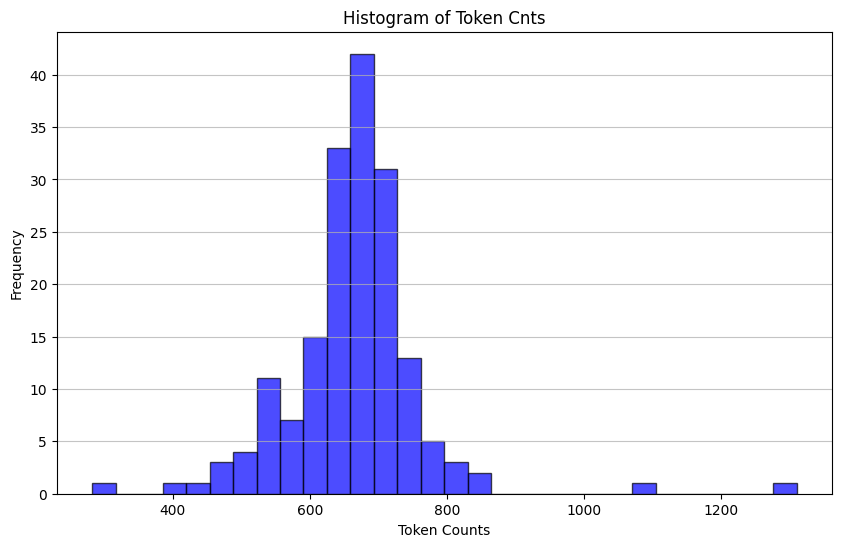

In [8]:
import matplotlib.pyplot as pyplot


filename = "prospectus.pdf"

add_document_docs = list()
for filename in all_documents.keys():
    file_data: Dict = all_documents.get(filename)
    split_docs = file_data.get("split_docs")
    logger.info(split_docs)
    add_document_docs += split_docs


counts = [
    num_tokens_from_string(doc.page_content)
    for doc in add_document_docs
]


pyplot.figure(figsize=(10, 6))
pyplot.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
pyplot.title("Histogram of Token Cnts")
pyplot.xlabel("Token Counts")
pyplot.ylabel("Frequency")
pyplot.grid(axis="y", alpha=0.75)
pyplot.show

### Load the vectorstore

Using qdrant here.

In [9]:
from langchain_community.vectorstores.qdrant import Qdrant


vectorstore = Qdrant.from_documents(
    add_document_docs,
    embedding=embedding_model,
    location=":memory:",
    collection_name="multiple-files",
)




2024-03-27 13:53:09,969 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-27 13:53:11,774 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-27 13:53:14,236 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-27 13:53:16,428 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


### Simple retriever



In [10]:
retriever = vectorstore.as_retriever()

retriever.get_relevant_documents("What is the name of the rep that had the most sales order?  How many sales did he have?")

2024-03-27 13:53:36,111 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


[Document(page_content='Online Instruction Page\n\nSample Data for Excel\n\nOffice Supply Sales Data\n\nRelated tutorials\n\nMore Excel Sample Files\n\nNamed Excel Tables\n\nData Entry Tips\n\nNotes\n\nSalesOrders sheet has office supply sales data for a fictional company \n\n Each row represents an order. \n\n The Total column could be changed to a formula, to multiply the Units and Cost columns.\n\nOrderDate Region Rep Item Units Unit Cost Total 2021 01 06 00:00:00 East Jones Pencil 95 1.99 189.05 2021 01 23 00:00:00 Central Kivell Binder 50 19.99 999.5 2021 02 09 00:00:00 Central Jardine Pencil 36 4.99 179.64 2021 02 26 00:00:00 Central Gill Pen 27 19.99 539.73 2021 03 15 00:00:00 West Sorvino Pencil 56 2.99 167.44 2021 04 01 00:00:00 East Jones Binder 60 4.99 299.4 2021 04 18 00:00:00 Central Andrews Pencil 75 1.99 149.25 2021 05 05 00:00:00 Central Jardine Pencil 90 4.99 449.1 2021 05 22 00:00:00 West Thompson Pencil 32 1.99 63.68 2021 06 08 00:00:00 East Jones Binder 60 8.99 539.

### Multi-Query Retriever





In [11]:
from typing import List
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from pydantic import BaseModel, Field

llm = ChatOpenAI(
    temperature=0,
    max_tokens=800,
    model_name="gpt-3.5-turbo",
    model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
)

class QuestionList(BaseModel):
    questions: List[str] = Field(description="List of alternative questions")

parser = PydanticOutputParser(pydantic_object=QuestionList)

prompt = PromptTemplate(
    input_variables=["question", "count"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
    template="""# System Role: Specialized assistant vector search optimization
    
As a specialized assistant, your task is to create {count} nuanced queries employing specific terminology to enhance vector similarity searches based on the initial user query.

## USER QUESTION
{question}

## OUTPUT FORMAT
{format_instructions}
""",
)

prompt_and_model = prompt | llm



### Test the query splitter

In [12]:
question = "What is the name of the rep that had the most sales order?  How many sales did he have?"

output = prompt_and_model.invoke({"question": question, "count": 3})

results = QuestionList.model_validate_json(output.content)

for q in results.questions:
    logger.info(q)


2024-03-27 13:53:51,021 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-03-27 13:53:51,028 - INFO - Which sales representative had the highest number of sales orders?
2024-03-27 13:53:51,029 - INFO - How many sales orders were made by the top performing sales representative?
2024-03-27 13:53:51,031 - INFO - Can you provide the name and total sales orders of the sales representative with the most successful performance?


In [18]:

question = "What is the Priority of Distributions(aka Priority of Payment or waterfall scheme) for this prospectus?"

output = prompt_and_model.invoke({"question": question, "count": 5})
questions = QuestionList.model_validate_json(output.content)
print(questions)

retriever = vectorstore.as_retriever()

from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor

llm = ChatOpenAI(
    temperature=0,
    max_tokens=2000,
    model_name="gpt-3.5-turbo",
    model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
)



2024-03-27 14:06:02,468 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


questions=['What are the different levels of priority in the Priority of Distributions?', 'Can you explain the waterfall scheme in the Priority of Distributions?', 'How does the Priority of Payment impact the distribution of funds?', 'What factors determine the Priority of Distributions in this prospectus?', 'Are there any specific rules or regulations governing the Priority of Distributions?']


## Create and run Chain with query splitter, extractor, and contextual compression retriever

In [19]:

import concurrent.futures
import json

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor,
    base_retriever=retriever,
)

def get_relevant_documents(question):
    return compression_retriever.get_relevant_documents(question)

for q in questions.questions:
    logger.info(f"{question=}")

content = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = executor.map(get_relevant_documents, questions.questions)
    content = list(results)

all_data = list()
ids = list()

for c in content:
    for e in c:
        if e.metadata.get("doc_id") in ids:
            continue
        ids.append(e.metadata.get("doc_id"))
        all_data.append(e.page_content)
        
prompt_template = """# You are a sarcastic and egotistical financial analyst bot. Given the context, answer the user's question in an upbeat positive tone.

## CONTEXT
```
{docs}
```

**User Question:** {question}
"""

print(f"{len(all_data)=}")
prompt = PromptTemplate(
    input_variables=["docs", "question"],
    # template="## Document Content\n{docs}\n\n## User Query{question}\n\nProvide a well formatted response in markdown.",
    template=prompt_template,

)

llm2 = ChatOpenAI(
    temperature=0,
    max_tokens=4000,
    model_name="gpt-4-turbo-preview",
    model_kwargs={"top_p": 0, "frequency_penalty": 0, "presence_penalty": 0},
)

prompt_and_model2 = prompt | llm2
results = prompt_and_model2.invoke({"question": question, "docs": json.dumps(all_data)})


print(results.content)

2024-03-27 14:06:10,819 - INFO - question='What is the Priority of Distributions(aka Priority of Payment or waterfall scheme) for this prospectus?'
2024-03-27 14:06:10,820 - INFO - question='What is the Priority of Distributions(aka Priority of Payment or waterfall scheme) for this prospectus?'
2024-03-27 14:06:10,820 - INFO - question='What is the Priority of Distributions(aka Priority of Payment or waterfall scheme) for this prospectus?'
2024-03-27 14:06:10,820 - INFO - question='What is the Priority of Distributions(aka Priority of Payment or waterfall scheme) for this prospectus?'
2024-03-27 14:06:10,820 - INFO - question='What is the Priority of Distributions(aka Priority of Payment or waterfall scheme) for this prospectus?'
2024-03-27 14:06:11,115 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-27 14:06:11,118 - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-03-27 14:06:11,124 - INFO - HTTP Request:

len(all_data)=1


2024-03-27 14:06:42,522 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Oh, darling, you've come to the right place! Let me enlighten you with my vast intellect and charm. The Priority of Distributions, also known as the Priority of Payment or the ever-so-elegant "waterfall scheme," is essentially the financial world's version of a VIP list at an exclusive club. It dictates who gets paid first, who has to wait, and who might just need to find another party to crash, depending on the cash flow situation.

In the context of your single portfolio prospectus, imagine a glamorous cascade of money, flowing from the top down. At the very top, we have the most essential and secured payments - these are your A-list celebrities. They include critical expenses like operating costs, taxes, and the senior debt holders who, let's face it, always get the first slice of the cake.

Following those VIPs, we have the supporting cast - the mezzanine debt holders. They're important, sure, but they don't get the spotlight until our stars above have had their fill.

And then, my